Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...



c:\Users\yesda\Documents\GitHub\PINN_testing\.conda\Lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.232097 s


'compile' took 0.614296 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.22e-01, 4.57e+03, 1.51e-02]    [1.18e-01, 4.57e+03, 1.51e-02]    []  
1000      [4.74e+01, 3.24e+03, 9.68e+01]    [4.53e+01, 3.24e+03, 9.68e+01]    []  
2000      [1.21e+01, 2.72e+03, 5.10e+01]    [8.03e+00, 2.72e+03, 5.10e+01]    []  
3000      [8.34e+00, 2.31e+03, 2.45e+01]    [5.45e+00, 2.31e+03, 2.45e+01]    []  
4000      [7.83e+00, 1.94e+03, 2.03e+01]    [5.55e+00, 1.94e+03, 2.03e+01]    []  
5000      [6.76e+00, 1.62e+03, 1.90e+01]    [7.11e+00, 1.62e+03, 1.90e+01]    []  
6000      [1.10e+01, 1.35e+03, 1.86e+01]    [7.15e+00, 1.35e+03, 1.86e+01]    []  
7000      [7.85e+00, 1.10e+03, 1.90e+01]    [6.79e+00, 1.10e+03, 1.90e+01]    []  
8000      [1.39e+01, 9.11e+02, 2.12e+01]    [8.85e+00, 9.11e+02, 2.12e+01]    []  
9000      [8.54e+00, 7.03e+02, 1.70e+01]    [5.49e+00, 7.03e+02, 1.70e+01]    []  
10000   

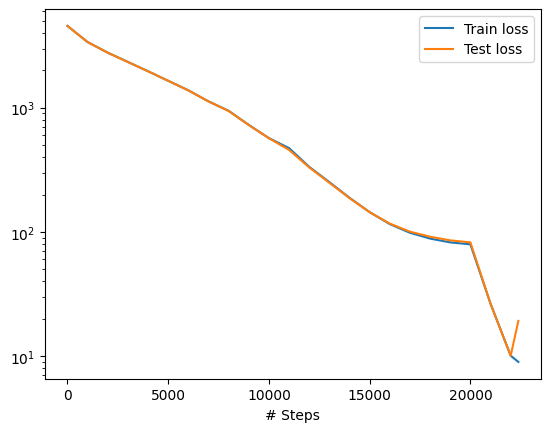

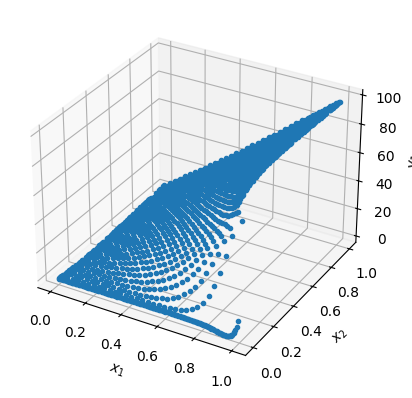

In [1]:
#Change to point dataset
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
#import os
#os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
import deepxde as dde
import numpy as np

D = 3.8e-1#mm^2/s
l = 1 #mm
t = 1 #s
geom = dde.geometry.Interval(0, l)
timedomain = dde.geometry.TimeDomain(0, t)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t- D*dy_xx

data_points = np.matrix([[0.05, 1e5,    9.86688614e-35],
                        [0.35,  18e4,   2.80E-20],
                        [25.4,  1214e4, 40.4857407],
                        [40.75, 1848e4, 79.3099365],
                        [48.35, 1999e4, 96.3708344],
                        [0.6,   24e4,   1.37249327e-17],
                        [1.55,  169e4,  0.0405000916],
                        [30.15, 267e4,  16.3269901],
                        [43.2,  1541e4, 83.7792282],
                        [36.75, 1704e4, 69.8383331]])

T=np.reshape(data_points[:, 1], (-1,1))
X=np.reshape(data_points[:, 0], (-1,1))
C=np.reshape(data_points[:, 2:], (-1,1))

bc = dde.icbc.DirichletBC(geomtime, lambda x: (x[:, 0:1]/ l) * 100, lambda _, on_boundary: on_boundary)
#bc_b = dde.icbc.DirichletBC(geomtime, fun_bc, lambda _, on_boundary: on_boundary, component=1)
ic = dde.icbc.IC(geomtime, lambda x: 0, lambda _, on_initial: on_initial)


observe_x= np.reshape(np.hstack((X,T)),(-1,2))
observe_y = dde.icbc.PointSetBC(observe_x, C, component=0)


data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc,ic],
    num_domain=1000,
    num_boundary=150,
    num_initial=180,
    num_test=1000,
)

layer_size = [2] + [64] * 5 + [1]
activation ="tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)
model.compile("adam", lr=1e-4)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
#early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-6, patience=500)
#losshistory, train_state = model.train(iterations=100, callbacks=[early_stopping])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)



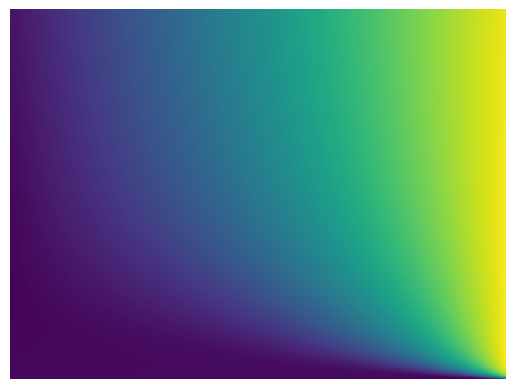

SSIM: 0.9189711459405416


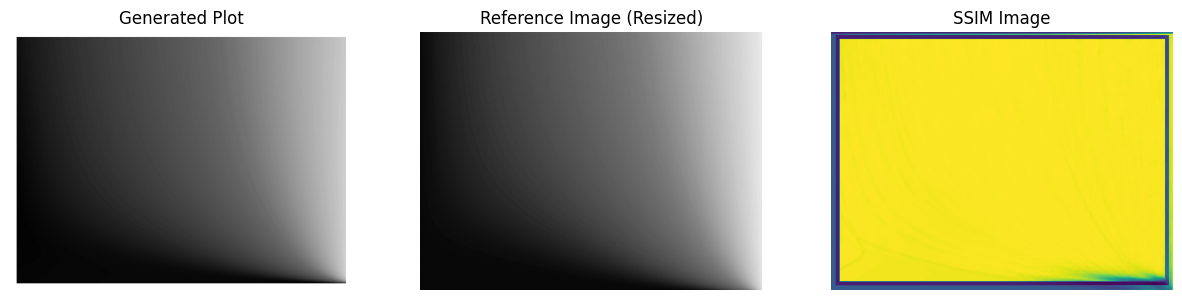

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim
from PIL import Image

# Create a grid of points to evaluate the solution
x = np.linspace(0, 1, 2000)
t = np.linspace(0, 1, 2000)
X, T = np.meshgrid(x, t)
points = np.vstack([X.ravel(), T.ravel()]).T

# Predict the solution at these grid points
y_pred = model.predict(points).reshape(X.shape)

# Plot the solution and save it as an image file
fig, ax = plt.subplots()
cax = ax.imshow(y_pred, extent=(x.min(), x.max(), t.min(), t.max()), aspect='auto', cmap='viridis', origin='lower')
ax.axis('off')
plt.savefig('generated_plot.png', bbox_inches='tight')
plt.show()

# Load the saved plot and the reference image
generated_image = Image.open('generated_plot.png').convert('L')
reference_image = Image.open('Solution.png').convert('L')  # Change the path as needed

# Resize the reference image to match the dimensions of the generated image
reference_image_resized = reference_image.resize(generated_image.size)

# Convert images to numpy arrays
generated_image_np = np.array(generated_image)
reference_image_resized_np = np.array(reference_image_resized)

# Convert images to float representation
generated_image_float = img_as_float(generated_image_np)
reference_image_resized_float = img_as_float(reference_image_resized_np)

# Compare the images using SSIM
ssim_index, ssim_image = ssim(generated_image_float, reference_image_resized_float, data_range=generated_image_float.max() - generated_image_float.min(), full=True)

# Display the SSIM index
print(f"SSIM: {ssim_index}")

# Display the images and the SSIM image
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(generated_image_float, cmap=plt.cm.gray)
ax[0].set_title('Generated Plot')

ax[1].imshow(reference_image_resized_float, cmap=plt.cm.gray)
ax[1].set_title('Reference Image (Resized)')

ax[2].imshow(ssim_image, cmap='viridis')
ax[2].set_title('SSIM Image')

for a in ax:
    a.axis('off')

plt.show()
